In [1]:
import sys
sys.path.insert(0, '/vol/atlas/homes/ks3811/')

In [2]:
import matplotlib.pyplot as plt
from main import debugging
try:
    %matplotlib inline
except NameError:  # in case it's a script. 
    pass

import os
import menpo.io as mio
from menpo.image import Image
import numpy as np
from menpo.shape import PointTree, PointUndirectedGraph, PointCloud
from menpofit.dpm.utils import convolve_python_f, call_shiftdt
from menpofit.dpm import HogFeaturePyramid, DPMFitter, non_max_suppression_fast, clip_boxes, bb_to_lns, DPMLearner
from menpofit.dpm.fitter import tf_convole

In [3]:
from resnet_feature_pyramid import ResnetFeaturePyramid
from menpofit.dpm.main import get_model
# pickle_dev = '/vol/atlas/homes/ks3811/pickles/resnet/multipie'
# model_name = 'component_further_0.pkl'
resnet = ResnetFeaturePyramid()
# model = get_model(pickle_dev, model_name, resnet)
pickle_dev = '/vol/atlas/homes/ks3811/pickles/resnet/5x5_dpm_filters/pose_8'
learner = DPMLearner(feature_pyramid=resnet)
model = learner.build_model(pickle_dev, 2)
learner = DPMLearner(feature_pyramid=resnet)
# model = learner.build_model(pickle_dev, 0)

(337, 329)


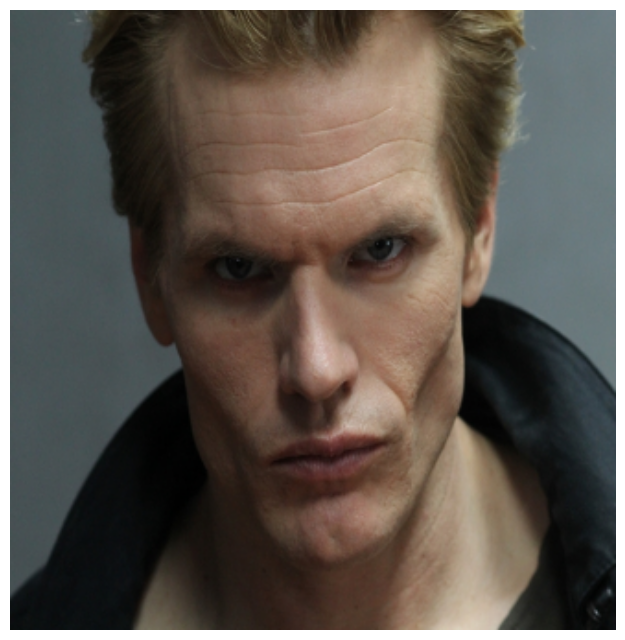

In [4]:
from ibugnet.utils import rescale_image
# image = mio.import_builtin_asset('takeo.ppm', normalize=False)
# image = mio.import_image('/vol/atlas/databases/aflw_ibug/face_52982.jpg', normalize=False)
image = mio.import_images('/vol/atlas/databases/300w/', normalize=False)[1]
# image = mio.import_image('/vol/atlas/homes/ks3811/matlab/INRIA/01687.jpg', normalize=False)
image = image.crop_to_landmarks_proportion(0.5)
image = image.resize([337, 329])



learner = DPMLearner()
pos, neg = learner._get_frontal_pie_image_info(pickle_dev)
# print(pos[112])

# image = mio.import_image(pos[0]['im'], normalize=False)
# image.landmarks['all'] = PointCloud(pos[112]['pts'])
# image = image.crop_to_landmarks_proportion(0.5)

# image = mio.import_images('/vol/atlas/databases/300w/', normalize=False)[1]
# image = image.crop_to_landmarks_proportion(0.5)
# image = image.resize((360, 350))
image.view()
print(image.shape)
# image = rescale_image(image)

In [5]:
feats, scales, shifts = model.feature_pyramid.extract_pyramid(image, model.interval, (19, 19))

In [6]:
feat = feats[0]
filters_all = model.get_filters_weights()
defs = model.get_defs_weights()
print(np.array(defs)[1].shape)
# filters_all = np.zeros((1, 69, 20, 20), dtype=np.float)
# filters_all[0, 1, :, :] = 1
print(np.array([feat]).shape)
print(np.array(filters_all).shape)
unary_scores_all = tf_convole(np.array([feat]), np.array(filters_all))[0]
# unary_scores_all = convolve_python_f(feat, filters_all)

(4,)
(1, 69, 375, 367)
(68, 69, 5, 5)


(375, 367)
0.992591


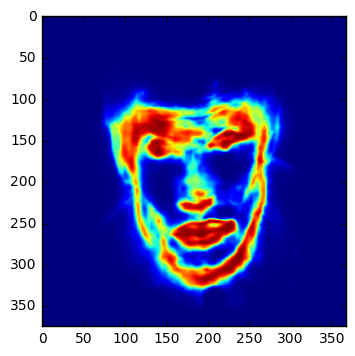

In [7]:
all_fea = np.sum(feat, axis=0) - feat[0, :, :]
print(all_fea.shape)
plt.imshow(all_fea)
print(np.max(all_fea))
# plt.imshow(feat[34, :, :])

(371, 363)


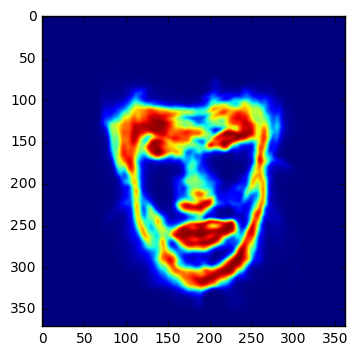

In [8]:
plt.imshow(unary_scores_all[0, :, :])
sum_score = np.sum(unary_scores_all, axis=0)
plt.imshow(sum_score)
# plt.imshow(sum_score)
print(sum_score.shape)
# padded_image.view(alpha=0.6)
# plt.imshow(feat[19, :, :])

In [9]:
variables = mio.import_pickle('/vol/atlas/homes/ks3811/pickles/fast_dpm/pose_6.pkl')
filters, defs2, defs, bias = variables
for i, part in enumerate(model.filters):
    part['w'] = filters[i, :, :]
for i, part in enumerate(model.defs):
    if i > 0:
#         defs[i, 0] = 0.01
#         defs[i, 2] = 0.01
        part['w'][0] = defs2[i, 0]
        if part['w'][0] <= 0.01:
            part['w'][0] = 0.01
        part['w'][2] = defs2[i, 1]
        if part['w'][2] <= 0.01:
            part['w'][2] = 0.01
        part['w'][1] = defs[i, 0]
        part['w'][3] = defs[i, 1]
model.defs[0]['w'] = bias

print(model.filters)

[{'w': array([[[ -1.08511951e-02,  -1.01615433e-02,  -9.68087092e-03,
          -9.41037294e-03,  -9.27986577e-03],
        [ -1.09033883e-02,  -1.02385236e-02,  -9.70765203e-03,
          -9.42449085e-03,  -9.36126802e-03],
        [ -1.09189982e-02,  -1.02792131e-02,  -9.75895766e-03,
          -9.49803554e-03,  -9.48490016e-03],
        [ -1.10057844e-02,  -1.04092630e-02,  -9.94633697e-03,
          -9.75056738e-03,  -9.80240759e-03],
        [ -1.14217633e-02,  -1.08061237e-02,  -1.03628691e-02,
          -1.02287922e-02,  -1.03738857e-02]],

       [[  1.19952355e-02,   1.14571862e-02,   1.11258123e-02,
           1.08661074e-02,   1.07138557e-02],
        [  1.13026239e-02,   1.08191613e-02,   1.04741491e-02,
           1.02040945e-02,   1.00172572e-02],
        [  1.07110618e-02,   1.01788947e-02,   9.78870317e-03,
           9.47506353e-03,   9.27374419e-03],
        [  1.05817840e-02,   9.83037613e-03,   9.22991894e-03,
           8.82288441e-03,   8.63132067e-03],
        [ 

(4,)
(1, 69, 375, 367)
(68, 69, 5, 5)
(375, 367)


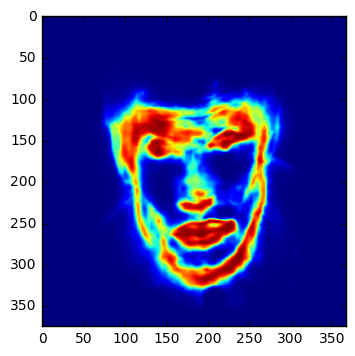

In [10]:
feat = feats[0]
filters_all = model.get_filters_weights()
defs = model.get_defs_weights()
print(np.array(defs)[1].shape)
# filters_all = np.zeros((1, 69, 20, 20), dtype=np.float)
# filters_all[0, 1, :, :] = 1
print(np.array([feat]).shape)
print(np.array(filters_all).shape)
unary_scores_all2 = tf_convole(np.array([feat]), np.array(filters_all))[0]
# unary_scores_all = convolve_python_f(feat, filters_all)

all_fea = np.sum(feat, axis=0) - feat[0, :, :]
print(all_fea.shape)
plt.imshow(all_fea)

0.547773


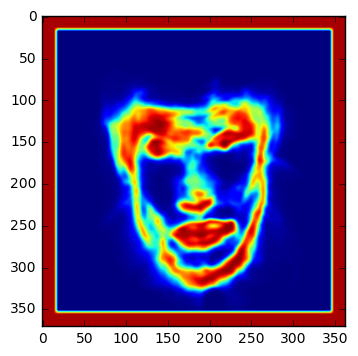

In [11]:
sum_score = np.sum(unary_scores_all2, axis=0)
plt.imshow(sum_score)
print(np.max(sum_score))
# plt.imshow(unary_scores_all[0, :, :])
# padded_image.view(alpha=0.6)
# plt.imshow(feat[0, :, :])

distance transform take: 0.49140024185180664
backtrack take: 0.09428143501281738
fitting tak: 0.9560432434082031
score: 7.336583614349365


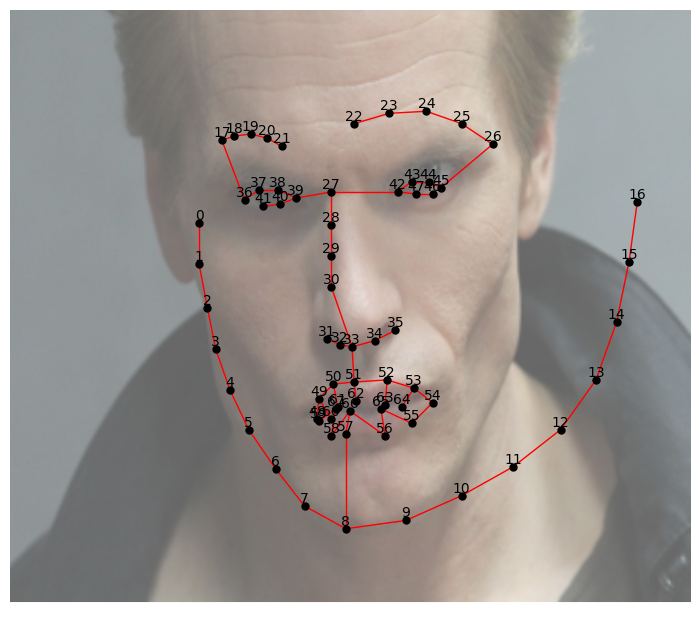

In [12]:
import time
start = time.time()
boxes = DPMFitter.fast_fit_from_model(image, model, 0, return_once=True)
stop = time.time()
print('fitting tak:', stop-start)
print('score:', boxes[0]['s'])

boxes.sort(key=lambda item: item['s'], reverse=True)
cc, pick = non_max_suppression_fast(clip_boxes(boxes), 0.3)
lns = bb_to_lns(boxes, pick)

tree = model.components[0]['tree']

new_tree = PointTree(lns[0], tree.adjacency_matrix.todense(), tree.root_vertex, skip_checks=True)
new_tree.view(render_numbering=True)

# image = image.crop_to_landmarks_proportion(0.2)
image.view(alpha=.6)
# print(model.get_filters_weights())

(69, 5, 5)
(5, 5)


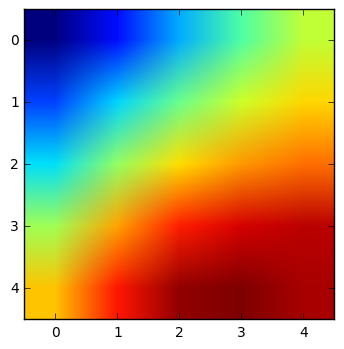

In [13]:
filters_all = model.get_filters_weights()
# print(filters_all[0])
print(np.array(filters_all)[0].shape)
sum_filter = np.sum(filters_all[0], axis=0)
print(sum_filter.shape)
plt.imshow(sum_filter)

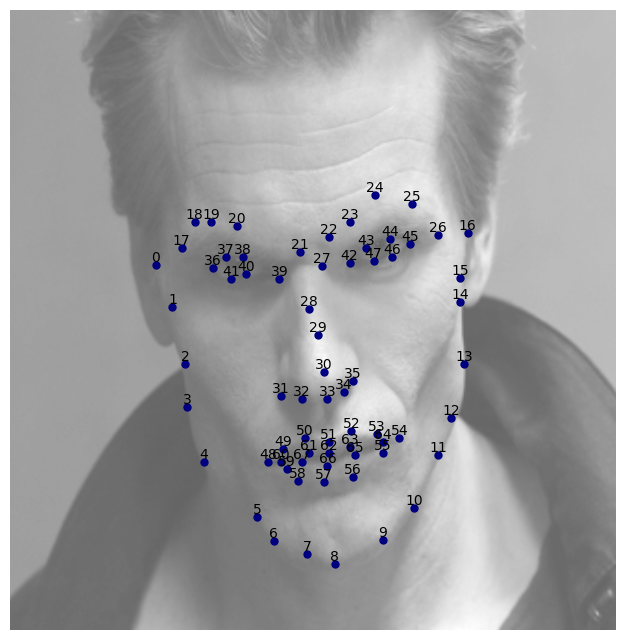

In [14]:
# plt.imshow(feat[18, :, :])
# filters_all = model.get_filters_weights()
# print(filters_all[0])
result = []
for point in range(1, 69):
    prob = feat[point, :, :]
    result.append(np.argwhere(prob.max() == prob)[0])
#     print(np.argwhere(prob.max() == prob))
result = np.array(result)
result -= 19
image.landmarks['face'] = PointCloud(result)
image.as_greyscale().view_landmarks(group='face', alpha=.6, render_numbering=True)

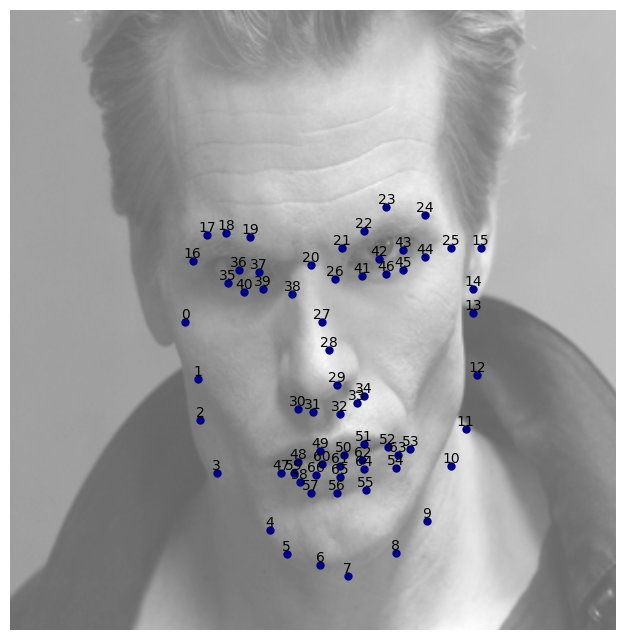

In [15]:
# print(unary_scores_all.shape)
# plt.imshow(unary_scores_all[1, :, :])
# plt.imshow(feat[2, :, :])
# image.view(alpha=0.6)

result = []
for point in range(1, 68):
    prob = unary_scores_all[point, :, :]
    result.append(np.argwhere(prob.max() == prob)[0])
#     print(np.argwhere(prob.max() == prob))
result = np.array(result)
result -= 10
image.landmarks['face2'] = PointCloud(result)
image.as_greyscale().view_landmarks(group='face2', alpha=.6, render_numbering=True)

In [16]:
learner = DPMLearner()
pos, neg = learner._get_frontal_pie_image_info(pickle_dev)
print(pos[101])

{'pts': array([[ 236.48447175,  271.45053508],
       [ 251.75480839,  270.68605383],
       [ 267.02347941,  272.43509947],
       [ 282.05704584,  275.16053526],
       [ 296.82761932,  278.8329966 ],
       [ 311.47359069,  283.34092008],
       [ 325.75265917,  288.88075723],
       [ 339.77440095,  294.74832767],
       [ 349.04035562,  306.32850688],
       [ 348.68650717,  333.03764157],
       [ 342.12292496,  358.76784332],
       [ 333.5317559 ,  383.92212535],
       [ 320.2147103 ,  406.59589909],
       [ 297.89967054,  420.57574487],
       [ 272.17430969,  427.1191044 ],
       [ 245.78322198,  431.3855829 ],
       [ 220.040133  ,  436.86123662],
       [ 191.02071167,  275.31979125],
       [ 189.08177458,  279.51401115],
       [ 188.86971774,  284.12932681],
       [ 189.73291349,  288.63983117],
       [ 192.31046373,  292.40900603],
       [ 191.6655877 ,  318.84892324],
       [ 185.7831846 ,  331.37610448],
       [ 182.61199333,  344.7800385 ],
       [ 181.2630

----------------


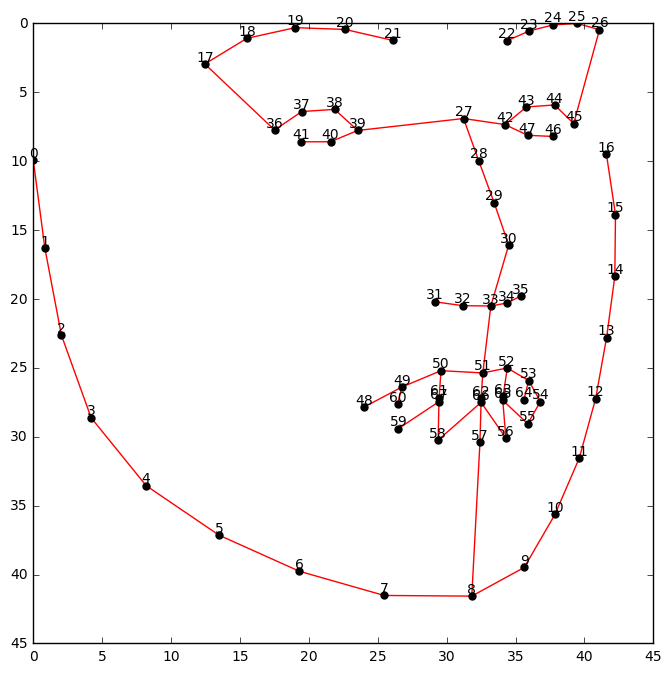

In [17]:
image = mio.import_image('/vol/hci2/Databases/video/MultiPIE/session01/png/001/01/05_1/001_01_01_051_05.png', normalize=False)
image.landmarks['all'] = PointCloud(pos[0]['pts'])
image = image.crop_to_landmarks_proportion(0.5)

# print(image.landmarks[image.landmarks.group_labels[0]].lms.points)
ys = image.landmarks[image.landmarks.group_labels[0]].lms.points[:, 0]
xs = image.landmarks[image.landmarks.group_labels[0]].lms.points[:, 1]

image.landmarks[image.landmarks.group_labels[0]].lms.points[:, 0] -= np.min(ys)
image.landmarks[image.landmarks.group_labels[0]].lms.points[:, 1] -= np.min(xs)

new_tree = PointTree(image.landmarks['all'].lms.points, tree.adjacency_matrix.todense(), tree.root_vertex, skip_checks=True)
# new_tree.view(render_numbering=True)
for cv in range(1, new_tree.n_vertices):
    par = new_tree.parent(cv)
#     print(new_tree.relative_location_edge(par, cv))
# image.view(alpha=0.6)

print('----------------')

from main import visualize_tree
points = visualize_tree()
min_ys = np.min(points[:, 0])
min_xs = np.min(points[:, 1])
points[:, 0]-=min_ys
points[:, 1]-=min_xs
model_tree = PointTree(points, tree.adjacency_matrix.todense(), tree.root_vertex, skip_checks=True)
model_tree.view(render_numbering=True)
for cv in range(1, model_tree.n_vertices):
    par = model_tree.parent(cv)
#     print(model_tree.relative_location_edge(par, cv))

# feas, defs, anchors = DPMFitter.get_positive_example_output(image, model)

In [18]:
# plt.imshow(feas[0].reshape(69, 20, 20)[1, :, :])
# plt.imshow(feas[0])
# print(feas.shape)

In [19]:
padding = (model.maxsize[0] - 1, model.maxsize[1] - 1)
feats, scales, shifts = model.feature_pyramid.extract_pyramid(image, model.interval, padding)

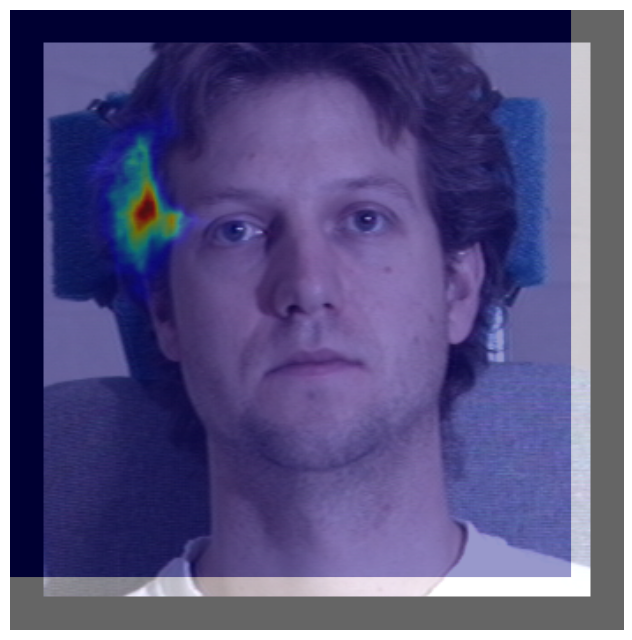

In [20]:
plt.imshow(feats[0][1, :, :])
# print(image.landmarks[image.landmarks.group_labels[0]].lms.points)
pixels = np.pad(image.pixels, ((0, 0), (19, 19), (19, 19)), 'constant')
padded_image = Image(pixels)
padded_image.view(alpha=0.6)
# image.view_landmarks(alpha=0.6)

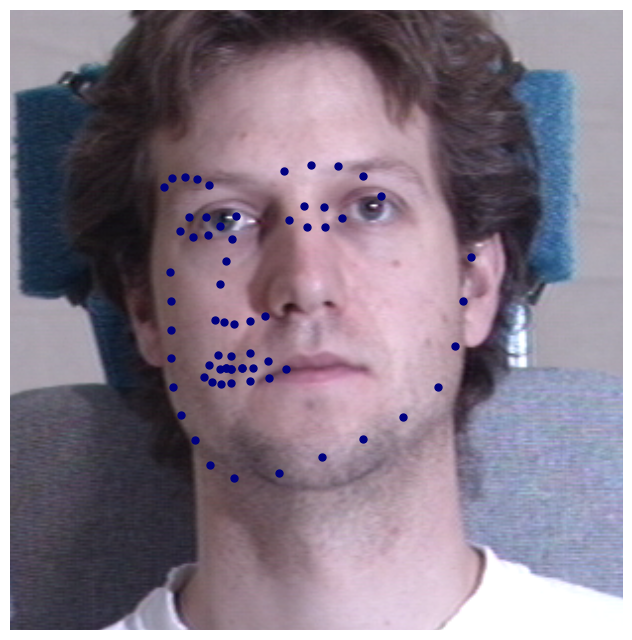

In [21]:
image = mio.import_image('/vol/hci2/Databases/video/MultiPIE/session01/png/001/01/05_1/001_01_01_051_05.png', normalize=False)
image.landmarks['all'] = PointCloud(pos[0]['pts'])
image = image.crop_to_landmarks_proportion(0.5)
feas, defs, anchors = DPMFitter.get_positive_example_output(image, model)
image.view_landmarks()

In [22]:
print(defs)

[[[  0.   0.   0.   0.]
  [ -1.   1.  -4.  -2.]
  [ -4.  -2.  -9.  -3.]
  [ -9.  -3.  -4.  -2.]
  [ -9.  -3.  -9.  -3.]
  [ -0.  -0.  -4.  -2.]
  [ -1.  -1.  -9.  -3.]
  [ -1.  -1.  -4.  -2.]
  [ -4.  -2.  -4.  -2.]
  [-16.  -4.  -9.  -3.]
  [-25.  -5.  -1.  -1.]
  [ -9.  -3.  -4.   2.]
  [ -4.  -2.  -9.   3.]
  [ -4.   2. -49.   7.]
  [ -0.  -0. -16.   4.]
  [ -1.  -1.  -9.   3.]
  [ -0.  -0. -16.   4.]
  [ -0.  -0. -64.   8.]
  [ -4.  -2.  -9.  -3.]
  [ -1.  -1.  -1.  -1.]
  [ -0.  -0.  -0.  -0.]
  [ -1.  -1.  -1.  -1.]
  [ -4.   2.  -4.  -2.]
  [ -9.   3.  -4.  -2.]
  [-16.   4.  -1.  -1.]
  [-16.   4.  -1.  -1.]
  [ -4.  -2. -81.   9.]
  [ -4.  -2.  -1.   1.]
  [ -1.  -1.  -4.   2.]
  [ -1.  -1.  -4.   2.]
  [ -1.   1. -16.   4.]
  [ -0.  -0.  -1.   1.]
  [ -1.   1.  -1.   1.]
  [ -1.   1.  -4.  -2.]
  [ -4.  -2.  -1.   1.]
  [ -1.  -1.  -1.   1.]
  [ -4.   2.  -1.   1.]
  [ -1.  -1.  -0.  -0.]
  [ -0.  -0.  -0.  -0.]
  [-16.   4.  -4.   2.]
  [ -1.   1.  -4.   2.]
  [ -1.   1.  -0

In [23]:
print(anchors.shape)
print(anchors)

(68, 3)
[[  0.   0.   0.]
 [ 18.   0.   0.]
 [ 18.   3.   0.]
 [ 18.   4.   0.]
 [ 18.   5.   0.]
 [ 17.   6.   0.]
 [ 17.   8.   0.]
 [ 16.  10.   0.]
 [ 10.  15.   0.]
 [  1.  28.   0.]
 [ -6.  27.   0.]
 [-10.  25.   0.]
 [-14.  23.   0.]
 [-20.  17.   0.]
 [-24.  10.   0.]
 [-25.   6.   0.]
 [-25.   5.   0.]
 [-28.  -7.   0.]
 [ -1.   7.   0.]
 [  1.   8.   0.]
 [  3.   8.   0.]
 [  4.   7.   0.]
 [  6. -15.   0.]
 [  2. -16.   0.]
 [ -3. -15.   0.]
 [ -8. -13.   0.]
 [-19.  24.   0.]
 [-12.   5.   0.]
 [-12.   5.   0.]
 [-12.   5.   0.]
 [-23.  -7.   0.]
 [ -2.  -4.   0.]
 [  0.  -5.   0.]
 [-14.   1.   0.]
 [ -1.  11.   0.]
 [ -3.  10.   0.]
 [  7.  -5.   0.]
 [  1.  -7.   0.]
 [ -4.  -6.   0.]
 [  4. -11.   0.]
 [  4.  -6.   0.]
 [  1.  -7.   0.]
 [  3.  32.   0.]
 [ -5.   8.   0.]
 [  2.  10.   0.]
 [  6.   9.   0.]
 [  1.  10.   0.]
 [  4.   9.   0.]
 [  8.  -1.   0.]
 [  5.  -5.   0.]
 [  0.  -6.   0.]
 [  2. -11.   0.]
 [ -3. -11.   0.]
 [ -4. -10.   0.]
 [ -6.  11.   0.]
 [

In [ ]:
model_anchors = model.get_defs_anchors()
print(model_anchors)

[array([ 0.,  0.,  0.]), array([ 18.,   0.,   0.]), array([ 18.,   3.,   0.]), array([ 18.,   4.,   0.]), array([ 18.,   5.,   0.]), array([ 17.,   6.,   0.]), array([ 17.,   8.,   0.]), array([ 16.,  10.,   0.]), array([ 10.,  15.,   0.]), array([  1.,  28.,   0.]), array([ -6.,  27.,   0.]), array([-10.,  25.,   0.]), array([-14.,  23.,   0.]), array([-20.,  17.,   0.]), array([-24.,  10.,   0.]), array([-25.,   6.,   0.]), array([-25.,   5.,   0.]), array([-28.,  -7.,   0.]), array([-1.,  7.,  0.]), array([ 1.,  8.,  0.]), array([ 3.,  8.,  0.]), array([ 4.,  7.,  0.]), array([  6., -15.,   0.]), array([  2., -16.,   0.]), array([ -3., -15.,   0.]), array([ -8., -13.,   0.]), array([-19.,  24.,   0.]), array([-12.,   5.,   0.]), array([-12.,   5.,   0.]), array([-12.,   5.,   0.]), array([-23.,  -7.,   0.]), array([-2., -4.,  0.]), array([ 0., -5.,  0.]), array([-14.,   1.,   0.]), array([ -1.,  11.,   0.]), array([ -3.,  10.,   0.]), array([ 7., -5.,  0.]), array([ 1., -7.,  0.]), 

In [ ]:
print(mio.import_pickle('/vol/atlas/homes/ks3811/pickles/resnet/5x5_dpm_filters/hard_negatives.pkl'))

In [ ]:
import sys
sys.path.insert(0, '/vol/atlas/homes/ks3811/')
import time
from resnet_feature_pyramid import ResnetFeaturePyramid
from menpofit.dpm.main import get_model
from menpofit.dpm import DPMLearner
start = time.time()
pickle_dev = '/vol/atlas/homes/ks3811/pickles/resnet/multipie'
model_name = 'component_0.pkl'
resnet = ResnetFeaturePyramid()
model = get_model(pickle_dev, model_name, resnet)
learner = DPMLearner()
feas, defs = learner.get_examples(model, pickle_dev)
stop = time.time()
print(stop-start)

In [ ]:
a = dict({'a':5})
print(a)

In [ ]:
import numpy as np
a = np.array([[0, 1], [2, 3], [3, 4]])
print(a)
b = a[np.array([1, 0]),:]
print(b)